<a href="https://colab.research.google.com/github/panford/ML4DD/blob/main/Notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Models for Molecule Generation

**Author**: Kobby Panford-Quainoo (panford.github.io)

**Institution:** African Institute for Mathematical Sciences

**Workshop:** International E-workshop on Machine Learning for Drug Discovery, India (05/21)


In this tutorial, we will look at how to generate molecules from the SMILES dataset using Adversarial Autoencoders (AAEs). 

In [ ]:
#@title Install condalab: We need to install condalab in order to install RDKits with Anaconda, Run this cell and wait for kernel to restart before running the next cells
!pip install -q condacolab

import condacolab
condacolab.install()

!conda install -q rdkit  #Install RDKits


⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:22
🔁 Restarting kernel...
Solving environment: ...working... done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - rdkit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    boost-1.74.0               |   py37h6dcda5c_3         342 KB  conda-forge
    boost-cpp-1.74.0           |       hc6e9bd1_3        16.3 MB  conda-forge
    cairo-1.16.0               |    h6cf1ce9_1008         1.5 MB  conda-forge
    conda-4.10.1               |   py37h89c1867_0         3.1 MB  conda-forge
    cycler-0.10.0              |             py_2           9 KB  conda-forge
    fontconfig-2.13.1          |    hba837de_1005         357 KB  conda-forge
    freetype-2.10.4        

In [ ]:
# Imports
import numpy as np 
import pandas as pd
from rdkit import Chem
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Model
from rdkit.Chem import Descriptors, QED
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import random_normal
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Lambda, Input, RepeatVector, LSTM, LeakyReLU, Dropout
from tensorflow.keras.layers import Embedding, Dense, Bidirectional, Concatenate, TimeDistributed

tf.random.set_seed(5)

In [ ]:
!git clone https://github.com/panford/ML4DD.git

In [ ]:
#@title Define utility functions for smiles computation here
def compute_smile_prop(smile):

  """ 
  Compute smiles properties (MolWt, LogP, QED)

  Inputs:
    smile (str, list, tuple) : A sequence or list of sequences of smiles 
                                data whose properties needs to be computed
  Output:
    props (list)  :   Computed properties
  
  """

  def compute_for_one(smi):

    """
    Computes properties for a single smile sequence

    Inputs 
      smi (str) : A sequence of smile characters
    Outputs
      prop (list): Computed properties, "Not exist" if properties cannot be computed
    """

    try:
        mol=Chem.MolFromSmiles(smi) 
        prop = [Descriptors.ExactMolWt(mol), Descriptors.MolLogP(mol), QED.qed(mol)]
    except:
        prop = 'Not exist!'
    return prop

      
  if isinstance(smile, (list, tuple)):
    all_list = []
    for s in list(smile):
      all_list.append(compute_for_one(s))
    props = all_list

  elif isinstance(smile, str):
    props = compute_for_one(smile) 
  else:
    print(f"Input must be a string or list, Instead got {type(smile)}")
    
  return props

def canonicalize(smile):
  """Function to canonicalise smiles inputs sequence"""

  return Chem.MolToSmiles(Chem.MolFromSmiles(smile))

In [ ]:
#@title Utility functions for decoding numerical sequences and generation
def greedy_search():
  """
  A decoder algorithm to retrieve sequences from decoder output

  Inputs
    inputs (tf-tensor): Output from decoder, size (batch, max_seq_len, num_chars)
  
  Outputs
    seq of greedily decoded sequences
  """
  def decode(preds):
    return np.argmax(preds).tolist()

  return decode



def temperature_sampling():
  """
  Temperature sampling wrapper function

  This wrapper function will allow us use the temperature sampling strategy to decode our predicted sequences
  """
  def softmax(z):
    """Softmax function """
    return np.exp(z)/sum(np.exp(z))

  def decode(preds, temperature):

    """ 
    Decoder using temperature 
    """

    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    reweighted_preds = softmax(preds)
    probs = np.random.multinomial(1, reweighted_preds, 1)

    return np.argmax(probs)

  return decode



def decode_preds(preds, d_strategy="temp", **decoder_params):

  """Decoding function: call this with decoder prediction
  Inputs
    preds (batch_size, max_seq_len, num_chars): softmax prediction from decoder model
    d_strategy (str):      Strategy to use for prediction
  """

  
  if d_strategy == "temp":
    strategy = temperature_sampling()
    temperature = decoder_params.get('temperature') or 0.5
    print('Decoding strategy: ', "Temperature Sampling (%s) "%temperature)

  elif d_strategy == 'greedy':
    strategy = greedy_search()
    print('Decoding strategy: ', "Greedy Search")
  print("*"*8)

  seqs = []
  for n in range(preds.shape[0]):
    batch = []
    for l in range(preds.shape[1]):
      batch.append(strategy(preds[n,l,:], temperature=temperature))
    seqs.append(batch)
  decoded_seq = tokenizer.sequences_to_texts(unpad(list(seqs)))
  seq = [s.replace(" ","") for s in decoded_seq]

  return seq


def generate_smiles_from_prior(model, prior, decoding_strategy = "temp", **decoder_params):
  
  """
  Generates smiles samples from prior

  Inputs
    batch_size: Batch size of samples to generate
    latent_dim: Latent dimension 

  outputs
    decoded_seq: Decoded sequence

  """

  predicted_seq = model.predict(prior)

  return decode_preds(predicted_seq, decoding_strategy, **decoder_params)


def unpad(input_tokens):
  """Function for unpadding tokens
  Inputs
    input_tokens  : list of input tokens
  Outputs
    unpadded tokens (list)
  """

  unpadded = []
  for i in range(len(input_tokens)):
    unpadded_list = [token for token in input_tokens[i] if token !=0]
    unpadded.append(unpadded_list)

  return unpadded


def generate_random_smiles(model, batch_size, latent_dim, decoding_strategy, **decoder_params):
  
  """
  Generates smiles samples from random normal samples

  Inputs
    batch_size: Batch size of samples to generate
    latent_dim: Latent dimension 
    model     : model to predict from prior

  outputs
    decoded_seq: Decoded sequence

  """

  prior = tf.random.normal(shape=[batch_size, latent_dim],)

  return generate_smiles_from_prior(model, prior, decoding_strategy, **decoder_params)

In [ ]:
#Lets get the data path
path_to_data = "/content/ML4DD/data/smiles.txt"

In [ ]:
# Load up data from path

smiles_data = pd.read_csv(path_to_data, header = None)
smiles_data = smiles_data[0][:2000] # THis is very huge so select the amount of data you can work with effectively

In [ ]:
compute_smile_prop(smiles_data[:5].tolist()) # Compute properties for the first 5 datapoints

[[217.05063234791, 0.1348999999999997, 0.7060511028948301],
 [289.07726434, 2.0300999999999996, 0.6535741974690973],
 [281.08341234000005, 1.6806999999999999, 0.8968983095288725],
 [281.08341234000005, 1.6806999999999999, 0.8968983095288725],
 [212.098334132, 1.3038, 0.5630097133159685]]

In [ ]:
smiles_data.head()

0            C[C@@]1(C(=O)C=C(O1)C(=O)[O-])c2ccccc2
1             c1ccc(cc1)C(c2ccccc2)[S@](=O)CC(=O)NO
2    CCC[S@](=O)c1ccc2c(c1)[nH]/c(=N\C(=O)OC)/[nH]2
3    CCC[S@](=O)c1ccc2c(c1)[nH]/c(=N/C(=O)OC)/[nH]2
4                  CC(C)C[C@@H]1C(=O)N(C(=S)N1)CC=C
Name: 0, dtype: object



---


Since we are using data represented as SMILES strings, we can use some natual language processing techniques. We'll tokenize the characters which basically means selecting the set of unique characters in the entire dataset. Also in order to make up for the difference in lengths, we'll find the maximum sequence lengths and pad with zeros to the max sequence length. 


---






In [ ]:
# Create a tokenizer to tokenize the characters in the smiles dataset

tokenizer = Tokenizer(filters=None,
                      lower=False,
                      char_level=True)
tokenizer.fit_on_texts(smiles_data)

In [ ]:
print(tokenizer.word_index)

{'c': 1, 'C': 2, '(': 3, ')': 4, '1': 5, 'O': 6, '2': 7, '[': 8, ']': 9, '=': 10, 'N': 11, '3': 12, 'H': 13, '@': 14, 'n': 15, '+': 16, '4': 17, '-': 18, 'l': 19, '/': 20, 'S': 21, 'F': 22, 's': 23, 'o': 24, '#': 25, '\\': 26, 'B': 27, 'r': 28, '5': 29, 'I': 30, 'P': 31, '6': 32}


In [ ]:
def create_padded_data(smiles_):

  """
  Creates numerical dataset from character sequences and pads up to the max sequence length
  Inputs
    smiles_(list):  lists of sequences from data
  Outputs:
    (nd.array):     An array of padded sequences up to max sequence length
    max_seq_len (int): length of longest sequence in the data

  """
  
  x_sequences = [] 
  # Loop through each row
  for line in smiles_:
    token_list = tokenizer.texts_to_sequences([line])[0] #Tokenize each row
    x_sequences.append(token_list) # append to x_sequences

  # pad sequences 
  max_seq_len = max([len(x) for x in x_sequences]) # Compute max sequence length

  return np.array(pad_sequences(x_sequences, maxlen=max_seq_len, padding='pre')), max_seq_len

In [ ]:
X, max_seq_len = create_padded_data(smiles_data)
X[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  2,  8,  2, 14, 14,  9,  5,  3,  2,  3, 10,  6,
        4,  2, 10,  2,  3,  6,  5,  4,  2,  3, 10,  6,  4,  8,  6, 18,  9,
        4,  1,  7,  1,  1,  1,  1,  1,  7], dtype=int32)

In [ ]:
latent_dim = 10          # Dimension of latent vector 
batch_size = 100          # Batch size
embedding_dim = 100       # Embedding dimension
num_chars = len(tokenizer.word_index)+1 # Compute the number of characters or unique tokens
                                        # Add one for padding
n_units = 96         #Number of GRU units
learning_rate = 0.0002    # Learning rate for optimizer

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(X)  # Create a tensorflow dataset
train_dataset = dataset.batch(batch_size).shuffle(1024) # Add batching and shuffling

[Adversarial autoencoders](https://arxiv.org/pdf/1511.05644.pdf) combines ideas from two main generative models, autoencoders and generative adversarial networks. This idea was originally proposed by Alireza Makhzani et al(2005) and proposed for drug discovery application in the [druGAN](https://pubs.acs.org/doi/abs/10.1021/acs.molpharmaceut.7b00346) paper.

![link text](https://pubs.acs.org/na101/home/literatum/publisher/achs/journals/content/mpohbp/2017/mpohbp.2017.14.issue-9/acs.molpharmaceut.7b00346/20170829/images/medium/mp-2017-00346k_0007.gif)

Let's dissect the architecture a bit.
Just like the usual generative adversarial network, AAEs have a generator and a discriminator.  
- The generator is an autoencoder and that means, its made up of an encoder and a decoder. The encoder takes the input data and learns a compressed representation for it. 
- The decoder of the generator takes the latent code and attempts to reconstruct the original data from it just as the autoencoder does.
- The discriminator is a simple network that also makes sure that the latent code learnt by the encoder is from some prior distribution. 
- For instance, if we want to impose a gaussian distribution on the latent code, we simply sample from the gaussian distribution as a prior. This makes it easy for us to generate data by simply sampling from a gaussian distribution and reconstructing with the decoder.

Then the discriminator has the task of detecting whether a given input comes from the prior distribution or from the encoder. This game continues till 
* the generator's encoder gets better at learning a latent code that comes from the prior distribution
- the decoder gets better at reconstructing the data from the input latent code
- The discriminator gets better at differentiating between samples that come from the prior and ones that comes from the encoder.





Training the adversarial autoencoder is done in 2 phases; the reconstruction phase and the regularisation phase.

- In the reconstruction phase, the generator is trained to minimize reconstruction error.
- In the regularization phase, the discriminator is trained to minimize its discriminatory loss and also the encoder is trained to produce a latent code that looks more and more like one that comes from the prior distribution.


Now, lets implement the various components of the AAE.
- First we create an encoder, a decoder for the generator
  - The encoder takes in input SMILES data to produce the latent code
  - The decoder accepts the latent code and produces a distribution of the number of unique characters in the SMILES dataset. A decoding strategy is then needed to convert the softmax distribution to text or character sequences. Some of the decoding strategies are: greedy search, beam search, temperature sampling, top-k sampling etc.

- Next we create a discriminator.


NB: You could replace the autoencoder with a variational autoencoder and in this case the generator will be trained the same way, VAEs are trained with KL objective.

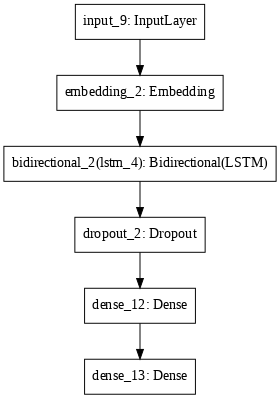

In [ ]:
def encoder_model(num_chars, embedding_dim, max_seq_len, latent_dim, n_units):

  '''
  Encoder 

  Inputs
    num_chars (int)      : Number of unique characters in dataset
    embedding_dim (int)  : Embedding dimension
    max_seq_len (int)    : max sequence length
    latent_dim (int)     : latent dimension
    n_gru_units (int)    : number of gru units

  Outputs
    (Keras Model Object) : takes data inputs and returns parameters of learned latent distribution 
  '''

  inputs = Input(shape = (max_seq_len, ))
  embedding = Embedding(num_chars, embedding_dim, input_length=max_seq_len, mask_zero=True)(inputs)
  x = Bidirectional(LSTM(n_units))(embedding)
  x = Dense(latent_dim*2, activation='relu')(x)
  z = Dense(latent_dim)(x)


  # Uncomment this part to do variational 
  # --------------------------------------
  # mu = Dense(latent_dim)(x)
  # sigma = Dense(latent_dim)(x)
  # model = Model(inputs, outputs = [mu, sigma])

  model = Model(inputs, z) # comment out if doing autoencoder
  
  return model

plot_model(encoder_model(num_chars, embedding_dim, max_seq_len, latent_dim, n_units), dpi=70)

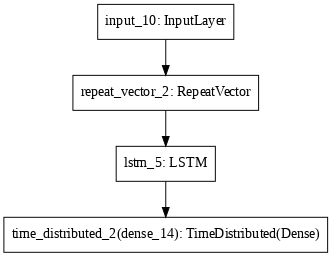

In [ ]:
def decoder_model(num_chars, max_seq_len, latent_dim, n_units):

  """
  Decoder 

  Inputs
    num_chars (int)      : Number of unique characters in dataset
    max_seq_len (int)    : max sequence length
    latent_dim (int)     : latent dimension
    n_gru_units (int)    : number of gru units

  Outputs
    (Keras Model Object) : takes latent vectors as inputs and returns a 
                           softmax distribution over character set 
  """

  inputs = Input(shape = (latent_dim))
  x = RepeatVector(max_seq_len)(inputs)
  x = LSTM(n_units, return_sequences=True)(x)
  output = TimeDistributed(Dense(num_chars, activation='softmax'))(x)
  model = Model(inputs, output)
  
  return model

plot_model(decoder_model(num_chars, max_seq_len, latent_dim, n_units), dpi=70)

In [ ]:
# Uncomment to do variational

# def reparameterize(inputs):

  
#   """
#   Reparameterization function--> takes mean and sigma and reparameterize with samples
#    drawn from a standard normal distribution with mean 0 and standard deviation 1. 

#   Inputs:
#    (mu, sigma): mean and standard deviation 

#   Output:
#     z (matrix, size (batch_dim, latent_dim)): latent vectors 

#    """
#   mu, sigma = inputs
#   n_samples = tf.shape(mu)[0]
#   dim = tf.shape(mu)[1]
#   eps = random_normal((n_samples, dim))
  
#   return mu + tf.exp(0.5*sigma) * eps

In [ ]:
# Uncomment to do variational
# def kl_divergence_loss(mu, sigma):
  
#   """ 
#   Computes the Kullback-Leibler Divergence (KLD) loss
#   Inputs
#     inputs:  batch from the dataset
#     outputs: Output from the sample_z function/ layer
#     mu:      mean
#     sigma:   standard deviation

#   Outputs:
#     KL Divergence loss
#   """

#   kl_loss = 1 + sigma - tf.square(mu) - tf.math.exp(sigma)
#   kl_loss = tf.reduce_mean(kl_loss) * -0.5

#   return kl_loss

In [ ]:
def autoencoder_model(encoder, decoder, max_seq_len):

  
  """
  Biulds a complete VAE model

  Inputs
    encoder: the encoder model
    decoder: the decoder model
    max_seq_len: length of sequence batch

  Output:
    the complete VAE model
  """

  # set the inputs
  inputs = tf.keras.layers.Input(shape=(max_seq_len, ))

  # Uncomment to do variational
  # mu, sigma = encoder(inputs)    # get mu and sigma from the encoder output
  # z = Lambda(reparameterize)(([mu, sigma]))
  z = encoder(inputs)
  reconstructed = decoder(z)    # get reconstructed output from the decoder

  model = tf.keras.Model(inputs=inputs, outputs=reconstructed) # define the inputs and outputs of the VAE

  # add the KL loss
  # loss = kl_divergence_loss(mu, sigma)
  # model.add_loss(loss)

  return model

In [ ]:
def generator_model(encoder, discriminator, max_seq_len):

  inputs = tf.keras.layers.Input(shape=(max_seq_len, ))
  z = encoder(inputs)
  disc_pred = discriminator(z)
  model = tf.keras.Model(inputs=inputs, outputs=disc_pred) 

  return model

In [ ]:
def sample_prior(batch_size, latent_dim):

  """
  Sample prior       :  Sample for random normal distribution
  Inputs:
    batch_size (int) : number of samples to generate
    latent_dim (int) : latent dimension

  Outputs
    samples from normal distribution (size = (batch_size, latent_dim))
  """

  return random_normal((batch_size, latent_dim))

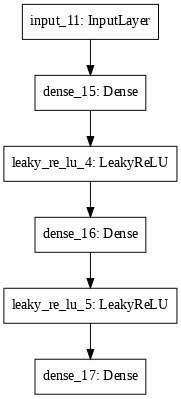

In [ ]:
def discriminator_model(latent_dim):


  """
  Define discriminator
  Inputs
    latent_dim: latent dimension

  Outputs
    discriminator model 
  """


  inputs = Input(shape=(latent_dim, ))
  x = Dense(64)(inputs)
  x = LeakyReLU(alpha=0.2)(x)
  x = Dense(32)(x)
  x = LeakyReLU(0.2)(x)
  outputs = Dense(1, activation="sigmoid")(x)
  
  model = Model(inputs, outputs)
  
  return model

plot_model(discriminator_model(latent_dim), dpi=70)

Now, lets define our loss functions and optimizers. We can use SGD, Adam or other optimizers. Its great to try things :)
- For losses, we use the sparse categorical cross entropy loss for the reconstruction of sparse categorical SMILES inputs and the reconstruction. This will be for the autoencoder (generator). 
- For the discriminator, we'll use a binary cross entropy loss since the discriminator is only trying to distinguish between two class (fake or real)

---



---



In [ ]:
# Define our loss functions and optimizers
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
ae_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss_metric = tf.keras.metrics.Mean()

spce_loss = tf.keras.losses.SparseCategoricalCrossentropy()
bce_loss = tf.keras.losses.BinaryCrossentropy()

In [ ]:
# Initialize model
def init_models(num_chars, embedding_dim, max_seq_len, latent_dim, n_units):
  """Initialize models """
  #init encoder & decoder
  encoder = encoder_model(num_chars, embedding_dim, max_seq_len, latent_dim, n_units)
  decoder = decoder_model(num_chars, max_seq_len, latent_dim, n_units)

  # Init discriminator and generator (generator --> discriminator)
  discriminator = discriminator_model(latent_dim)
  generator = generator_model(encoder, discriminator, max_seq_len)

  # Init generator / autoencoder = encoder + decoder
  autoencoder = autoencoder_model(encoder, decoder, max_seq_len)

  return encoder, decoder, generator, discriminator, autoencoder

In [ ]:
encoder, decoder, generator, discriminator, autoencoder = init_models(num_chars, embedding_dim, max_seq_len, latent_dim, n_units)
discriminator.trainable = False 

In the training loop, we take a minibatch of the data at a time, sample an equivalent number of samples as the batch of data and update the network parameters alternatingly in the reconstruction and regularization phases. Notice that we set the `discriminator.trainables` to True when training the discriminator and False when training only the generator

In [ ]:
# Training loop. 


epochs = 100 # Set the number of training epochs
disc_loss = []
gen_loss = []
avg_recon_loss = []
for epoch in range(epochs):
  # iterate over the batches of the dataset.
  for step, batch in enumerate(train_dataset):

    #  RECONSTRUCTION PHASE
    # -----------------------------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------------------------

    with tf.GradientTape() as rtape:
      noise = tf.random.normal(shape=[batch_size, latent_dim])
      generator.trainable = True
      # feed a batch to the VAE model
      reconstructed = autoencoder(batch)                                             # Get a batch of the training examples and feed to the model
    
      recon_loss = spce_loss(batch, reconstructed)                                   # compute the reconstruction loss between data and reconstruction
      # recon_loss += sum(generator.losses)                                          # add the KL Divergence loss to the reconstruction loss for vae
    
    recon_grads = rtape.gradient(recon_loss, autoencoder.trainable_weights)          # get the gradients with respect to the weights 
    ae_optimizer.apply_gradients(zip(recon_grads, autoencoder.trainable_weights))    # Update the weights with gradients

    loss_metric(recon_loss) # compute the mean of losses


    # REGULARIZATION PHASE
    # -----------------------------------------------------------------------------------------------------------------
    # -----------------------------------------------------------------------------------------------------------------

    # Discriminator Training
    with tf.GradientTape() as dtape:
      noise = sample_prior(batch_size, latent_dim)                                   # Sample from the prior distribution
      # z = encoder(batch)                                                           # Generate the latent distribution with the encoder of the generator
      # concat_data = tf.concat([noise, z], axis =0)                                 # Concatenate both the prior distribution and latent 
      discriminator.trainable = True  
                                                                                     # Set discriminator's weights as trainable 
      latent_pred = generator(batch)
      latent_labels = tf.zeros_like(latent_pred)

      prior_pred = discriminator(noise)                                              # Predict labels for prior
      prior_labels = tf.ones_like(prior_pred)                                        # Make labels for prior
      latent_loss = bce_loss(latent_labels, latent_pred)                             # compute crossentropy loss for latent
      prior_loss = bce_loss(prior_labels, prior_pred)                                # compute crossentropy loss for prior 

      disc_loss = (latent_loss + prior_loss)/2

    disc_grads = dtape.gradient(disc_loss, discriminator.trainable_weights)          # Compute gradients wrt discriminator weights
    disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_weights)) # Update weights

    
    # Generator training
    with tf.GradientTape() as gtape:

      discriminator.trainable = False                                                # Set discriminator weights to not trainable  
      batch_pred = generator(batch)                                                  # Predict labels for noise
      labels = tf.ones_like(batch_pred)                                              # Make labels to fool discriminator
      gen_loss = bce_loss(labels, batch_pred)                                        # Get loss from discriminator

    gen_grads = gtape.gradient(gen_loss, generator.trainable_weights)
    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_weights))


    # Show outputs at every 50 steps
    if step % 50 == 0:
      print('Epoch: %s\t step: %s \n average recon loss: %s \t disc loss: %s \t gen loss: %s' % (epoch, step, loss_metric.result().numpy(), disc_loss.numpy(), gen_loss.numpy()))

Epoch: 0	 step: 0 
 average recon loss: 3.4974911 	 disc loss: 0.7079675 	 gen loss: 0.6934743
Epoch: 0	 step: 50 
 average recon loss: 2.8911037 	 disc loss: 0.6999729 	 gen loss: 0.61236745
Epoch: 1	 step: 0 
 average recon loss: 2.7160344 	 disc loss: 0.46787906 	 gen loss: 1.1719172
Epoch: 1	 step: 50 
 average recon loss: 2.3852465 	 disc loss: 0.40495592 	 gen loss: 1.4087272
Epoch: 2	 step: 0 
 average recon loss: 2.3235176 	 disc loss: 0.40513408 	 gen loss: 1.29237
Epoch: 2	 step: 50 
 average recon loss: 2.1520147 	 disc loss: 0.51447034 	 gen loss: 0.8620775
Epoch: 3	 step: 0 
 average recon loss: 2.1100712 	 disc loss: 0.5657344 	 gen loss: 0.7221291
Epoch: 3	 step: 50 
 average recon loss: 1.996597 	 disc loss: 0.5972969 	 gen loss: 0.5767285
Epoch: 4	 step: 0 
 average recon loss: 1.9721652 	 disc loss: 0.65518636 	 gen loss: 0.5386651
Epoch: 4	 step: 50 
 average recon loss: 1.8981756 	 disc loss: 0.7795193 	 gen loss: 0.41742885
Epoch: 5	 step: 0 
 average recon loss: 1

In [ ]:
generate_random_smiles(decoder, 10, latent_dim, decoding_strategy='temp', temperature=0.5) # Lets generate some random samples with the trained decoder